
# Agentic AI Workshop 1
# Part 2: Embeddings & Similarity Metrics (No Vector DB Yet)


WHAT YOU'LL LEARN IN THIS NOTEBOOK:

1. What are embeddings?
   - Converting text into numerical vectors (arrays of numbers)
   - Why embeddings capture semantic meaning, not just keywords
   - How similar meanings result in similar vectors

2. Similarity Metrics
   - Cosine Similarity: Measures the angle between vectors (most common)
   - Euclidean Similarity: Measures the distance between vectors
   - When to use each metric

3. Document Retrieval Without a Database
   - How to find the most relevant documents for a query
   - Why this is the foundation of RAG (Retrieval-Augmented Generation)
   - Understanding the difference between keyword search and semantic search


In [4]:
import os
from openai import OpenAI
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../utils')
from helpers import load_env

In [5]:

# Load and verify API keys
load_env(api_key_type="OPENAI_API_KEY")

Environment variable 'OPENAI_API_KEY' has been loaded successfully.


In [6]:
# Outputs directory
OUTPUTS_DIR = './../outputs/'
os.makedirs(OUTPUTS_DIR, exist_ok=True)

In [7]:
# Initialize OpenAI client
client = OpenAI()  # Uses OPENAI_API_KEY from environment
print("Client ready.")

Client ready.


In [8]:

def get_embeddings(texts, model="text-embedding-3-small"):
    # Returns an array of shape (N, D)
    resp = client.embeddings.create(model=model, input=texts)
    return np.array([d.embedding for d in resp.data], dtype=np.float32)

In [9]:
def cosine_similarity(a, b):
    """Cosine similarity: measures angle between vectors (range: -1 to 1)"""
    a = a / (np.linalg.norm(a) + 1e-8)
    b = b / (np.linalg.norm(b) + 1e-8)
    return float(np.dot(a, b))

def euclidean_similarity(a, b):
    """Euclidean similarity: inverse of Euclidean distance (normalized to 0-1 range)"""
    distance = np.linalg.norm(a - b)
    # Convert distance to similarity (smaller distance = higher similarity)
    # Using exponential decay for better visualization
    similarity = np.exp(-distance / 10)
    return float(similarity)

# Dictionary of available similarity functions
SIMILARITY_METRICS = {
    "cosine": cosine_similarity,
    "euclidean": euclidean_similarity
}

In [10]:
# helper function to plot results
def plot_similarity_scores(df, query, metric_name, save_filename=None):
    """
    Create a horizontal bar chart showing document similarity scores.
    
    Args:
        df: DataFrame with 'title' and 'similarity' columns (sorted descending)
        query: The query string used for comparison
        metric_name: Name of the similarity metric used
        save_filename: Optional filename to save the chart (without path)
    """
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df["title"], df["similarity"], color='teal')
    plt.xlabel(f'{metric_name.title()} Similarity Score', fontsize=12)
    plt.ylabel('Document', fontsize=12)
    plt.title(f'Document Relevance to Query ({metric_name.title()} Similarity)\n"{query}"', 
              fontsize=14, pad=20)
    plt.xlim(0, 1)  # Normalized similarity range
    plt.gca().invert_yaxis()  # Highest score at top
    plt.grid(axis='x', alpha=0.3)

    # Add score labels at the end of each bar
    for bar, score in zip(bars, df["similarity"]):
        plt.text(bar.get_width() + 0.01,  # x position (slightly after bar end)
                 bar.get_y() + bar.get_height()/2,  # y position (center of bar)
                 f'{score:.3f}',  # score with 3 decimal places
                 va='center',  # vertical alignment
                 fontsize=10,
                 fontweight='bold')

    plt.tight_layout()

    # Save the chart if filename provided
    if save_filename:
        chart_path = os.path.join(OUTPUTS_DIR, save_filename)
        plt.savefig(chart_path, dpi=150, bbox_inches='tight')
        print(f"Chart saved to: {chart_path}")

    plt.show()

In [11]:
docs = [
    "Ready Tensor’s platform helps publish AI projects and evaluate models.",
    "RAG retrieves context from a knowledge base to ground LLM answers.",
    "Vector databases store embeddings and support fast similarity search.",
    "Prompt engineering shapes model behavior with clear instructions and constraints.",
    "Multi‑agent systems coordinate several specialized LLMs to solve complex tasks.",
]

query = "How do I ground a model’s answer in external knowledge?"

doc_embeddings = get_embeddings(docs)
query_embedding = get_embeddings([query])[0]

# Compute cosine similarities
scores = [cosine_sim(query_embedding, e) for e in doc_embeddings]
df = pd.DataFrame({
    "doc_id": range(len(docs)),
    "document": docs,
    "cosine_similarity": scores
}).sort_values("cosine_similarity", ascending=False)

df

NameError: name 'cosine_sim' is not defined

In [20]:
# Documents with more distinct topics
# Normally, you would read these from some knowledge base (docs can be pdfs, markdown, txt, etc.)
documents = [
    {
        "title": "Deep Learning",
        "content": "Deep learning uses neural networks with multiple layers to learn hierarchical representations from data. It excels at tasks like image recognition and natural language processing."
    },
    {
        "title": "Time Series Forecasting",
        "content": "Time series forecasting estimates future values based on historical patterns. Common methods include ARIMA, exponential smoothing, and recurrent neural networks for sequential data."
    },
    {
        "title": "Model Deployment",
        "content": "Model deployment involves packaging trained models into production systems. This includes creating APIs, containerization with Docker, and monitoring model performance in real-time."
    },
    {
        "title": "Feature Engineering",
        "content": "Feature engineering transforms raw data into meaningful inputs for machine learning models. Techniques include scaling, encoding categorical variables, and creating interaction terms."
    },
    {
        "title": "Anomaly Detection",
        "content": "Anomaly detection identifies unusual patterns that deviate from normal behavior. Applications include fraud detection, network security, and quality control in manufacturing."
    }
]

In [17]:
# CONFIGURATION: Choose similarity metric
# Options: "cosine" or "euclidean"
SIMILARITY_METRIC = "cosine"  # Change this to "euclidean" to try different metric

# Get the similarity function
similarity_func = SIMILARITY_METRICS[SIMILARITY_METRIC]



EXAMPLE 1 - Using COSINE similarity
QUERY: What's the best way to put my trained model into production?

Document Similarity Scores using COSINE (sorted by relevance):

                  title  similarity
       Model Deployment    0.625781
    Feature Engineering    0.329570
Time Series Forecasting    0.216214
          Deep Learning    0.209656
      Anomaly Detection    0.115798

Chart saved to: ./../outputs/similarity_example1_cosine.png


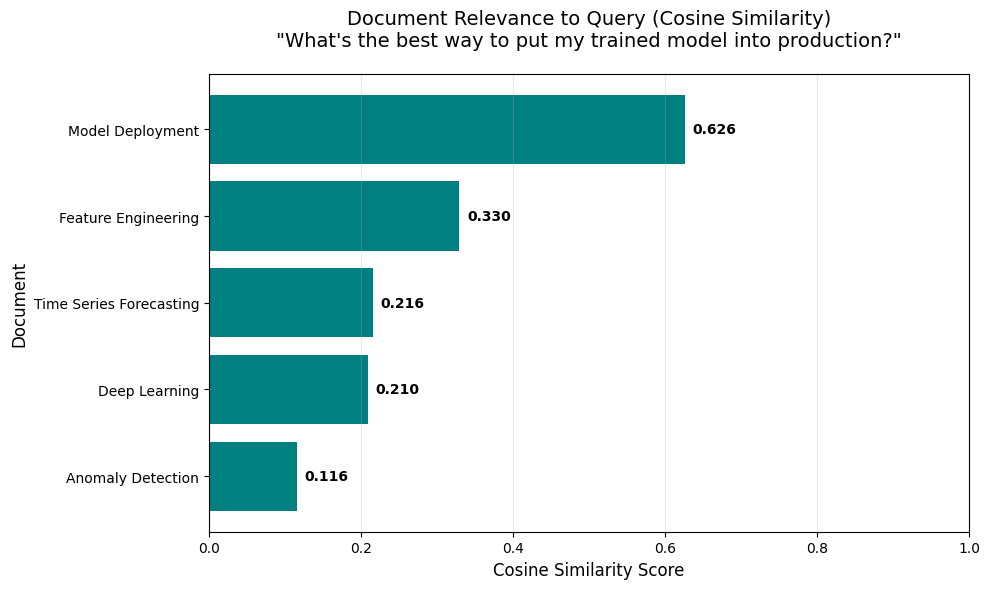

In [18]:
# EXAMPLE 1: Query about deployment

query1 = "What's the best way to put my trained model into production?"

print("\n" + "="*80)
print(f"EXAMPLE 1 - Using {SIMILARITY_METRIC.upper()} similarity")
print("="*80)
print(f"QUERY: {query1}")
print("="*80)

# Extract content for embeddings
doc_contents = [doc["content"] for doc in documents]
doc_titles = [doc["title"] for doc in documents]

# Get embeddings for Example 1
doc_embeddings = get_embeddings(doc_contents)
query1_embedding = get_embeddings([query1])[0]

# Compute similarities
scores1 = [similarity_func(query1_embedding, e) for e in doc_embeddings]

# Create dataframe
df1 = pd.DataFrame({
    "title": doc_titles,
    "document": doc_contents,
    "similarity": scores1
}).sort_values("similarity", ascending=False)

print(f"\nDocument Similarity Scores using {SIMILARITY_METRIC.upper()} (sorted by relevance):\n")
print(df1[["title", "similarity"]].to_string(index=False))
print("\n" + "="*80)

# Plot Example 1
plot_similarity_scores(df1, query1, SIMILARITY_METRIC, 
                      save_filename=f'similarity_example1_{SIMILARITY_METRIC}.png')



EXAMPLE 2 - Using COSINE similarity
QUERY: How can I predict stock prices for the next quarter?

Document Similarity Scores using COSINE (sorted by relevance):

                  title  similarity
Time Series Forecasting    0.424022
    Feature Engineering    0.191484
       Model Deployment    0.186194
      Anomaly Detection    0.140986
          Deep Learning    0.080338

Chart saved to: ./../outputs/similarity_example2_cosine.png


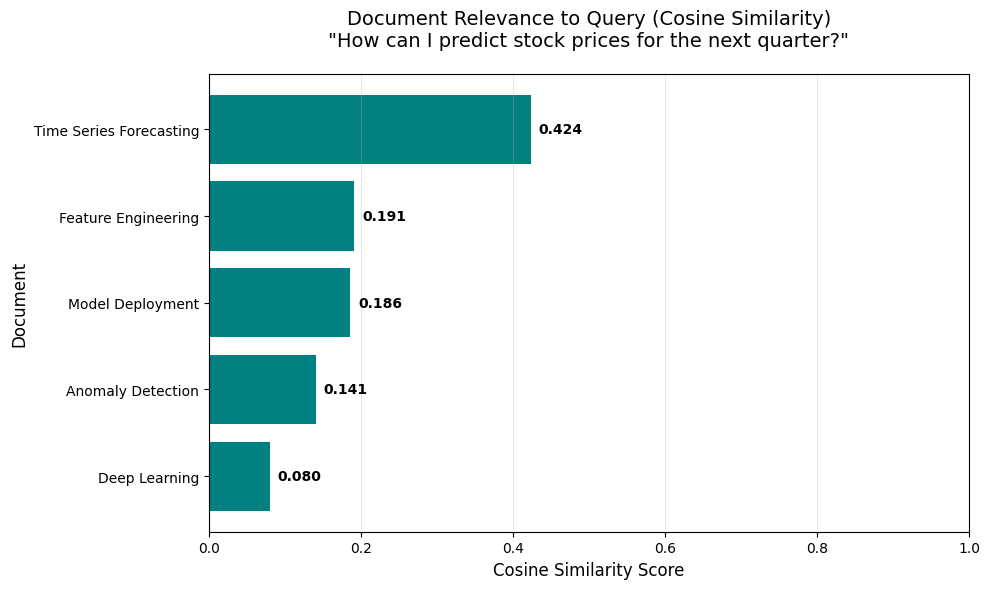

In [21]:
# EXAMPLE 2: Query about temporal data

query2 = "How can I predict stock prices for the next quarter?"

print("\n" + "="*80)
print(f"EXAMPLE 2 - Using {SIMILARITY_METRIC.upper()} similarity")
print("="*80)
print(f"QUERY: {query2}")
print("="*80)

# Get embeddings for Example 2 (reuse doc_embeddings)
query2_embedding = get_embeddings([query2])[0]

# Compute similarities
scores2 = [similarity_func(query2_embedding, e) for e in doc_embeddings]

# Create dataframe
df2 = pd.DataFrame({
    "title": doc_titles,
    "document": doc_contents,
    "similarity": scores2
}).sort_values("similarity", ascending=False)

print(f"\nDocument Similarity Scores using {SIMILARITY_METRIC.upper()} (sorted by relevance):\n")
print(df2[["title", "similarity"]].to_string(index=False))
print("\n" + "="*80)

# Plot Example 2
plot_similarity_scores(df2, query2, SIMILARITY_METRIC, 
                      save_filename=f'similarity_example2_{SIMILARITY_METRIC}.png')